In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import datasets, linear_model, metrics, feature_extraction, model_selection, tree, ensemble
from matplotlib import pyplot as plt
import seaborn as sns
import math
plt.style.use("ggplot")
%matplotlib inline
import gc
import json
from win10toast import ToastNotifier

In [2]:
notif = ToastNotifier()

In [27]:
def daysInMonth(x):
    return 28 + ((x + math.floor(x / 8)) % 2 + (2 % x) + (2 * math.floor(1/x)))


daysFromYearStart = [0]
def getDaysFromYearStart(month, day):
    while len(daysFromYearStart) <= month:
        l = len(daysFromYearStart)
        daysFromYearStart.append(daysFromYearStart[l - 1] + daysInMonth(l))
    return daysFromYearStart[month] - (daysInMonth(month) - day)


def dropRare(frame, clsName, minCount):
    counts = frame[clsName].value_counts()
    return frame.drop(df[df[clsName].isin(counts[counts < minCount].index)].index)

def logit(x):
    return math.log(np.abs(x / (1 - x)))

def logit_vec(v):
    return logit(v.mean() + 1e-5)

def reclassMeanOpt(frame, targetSrc, clsName, meanName, drop=False):
    if meanName in frame.columns:
        if drop:
            print("%s found in dataframe, drop=True, dropping" % meanName)
            frame = frame.drop(meanName, axis=1)
        else:
            print("%s found in dataframe, drop=False, skipping" % meanName)
            return frame
    mean_frame = targetSrc[[clsName, 'target']].groupby(clsName).agg(logit_vec).reset_index()
    mean_frame.rename(columns={'target':meanName}, inplace = True)
    return pd.merge(frame, mean_frame, on=clsName, how='left')
    
    
def reclassMean(frame, targetSrc, clsName, meanName, targetExtractor = lambda f, c: f[[c, 'target']].groupby(c).mean(), excluders=[]):
    def getMean(c): 
        if c not in meanInfo or c in excluders:
            meanInfo[c] = meanInfo.mean()
        return meanInfo[c]
    meanInfo = targetExtractor(targetSrc, clsName)
    frame[meanName] = frame[clsName].map(lambda c: getMean(c))
        
    
def split_time(time):
    time = str(int(time))
    time = ('0' * (4 - len(time))) + time
    hours = int(time[0:2])
    minutes = int(time[2:4])
    return {"H": hours, "M": minutes}


def reclass_time(frame, orig, hours, minutes): 
    t = frame[orig].map(split_time)
    frame[hours] = t.map(lambda t: t["H"])
    frame[minutes] = t.map(lambda t: t["M"])
    
def roc_curve(label, pred):
    fpr, tpr, _ = metrics.roc_curve(label, pred[:,1])
    plt.plot(fpr, tpr, label = 'linear model')
    plt.fill(fpr, tpr, alpha=0.5)
    plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right");
    plt.show()

In [4]:
df = pd.read_csv("train_dataset.csv")
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,target
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,DFW,190,15.0,13.0,1
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,DTW,207,9.0,24.0,1
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,RDU,532,3.0,27.0,0
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,LGA,1147,6.0,8.0,1
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,FLL,1972,9.0,21.0,1


In [5]:
df = df.dropna()
df = df.drop(df[df["AirTime"] == 0].index)

In [6]:
df = dropRare(df, "FlightNum", 20)
df = dropRare(df, "Dest", 5)
df = dropRare(df, "Origin", 5)

In [7]:
df["DayOfYear"] = df.apply(lambda x: getDaysFromYearStart(x["Month"], x["DayofMonth"]), axis=1)

In [8]:
df["AirTimeFrame"] = df["AirTime"].map(lambda x: math.log((x // 30) + 1, 10))

In [9]:
reclass_time(df, "DepTime", "DepHour", "DepMinute")
df["DepTotalMinutes"] = df["DepHour"] * 60 + df["DepMinute"]
df["DepTimeFrame"] = df["DepTotalMinutes"] // 15
df["DepHourOfYear"] = df["DayOfYear"] * 24 - (24 - df["DepHour"])

In [10]:
reclass_time(df, "ArrTime", "ArrHour", "ArrMinute")
df["ArrTotalMinutes"] = df["ArrHour"] * 60 + df["ArrMinute"]
df["ArrTimeFrame"] = df["ArrTotalMinutes"] // 15
df["ArrHourOfYear"] = df["DayOfYear"] * 24 - (24 - df["ArrHour"])

In [11]:
df["DistanceFrame"] = df["Distance"].map(lambda x: math.log((x // 30) + 1, 2))

In [12]:
gc.collect()
df["DepHourOfYearFrame"] = df["DepHourOfYear"] // 8
dhoy_origin_mean = df.groupby(["DepHourOfYearFrame", "Origin"])["target"].agg(logit_vec).reset_index()
dhoy_origin_mean.rename(columns={'target': 'DHOY_OriginChance'}, inplace=True)
df = pd.merge(df, dhoy_origin_mean, on=['DepHourOfYearFrame', 'Origin'], how='left')

In [13]:
gc.collect()
df["ArrHourOfYearFrame"] = df["ArrHourOfYear"] // 8
ahoy_dest_mean = df.groupby(["ArrHourOfYearFrame", "Dest"])["target"].agg(logit_vec).reset_index()
ahoy_dest_mean.rename(columns={'target': 'AHOY_DestChance'}, inplace=True)
df = pd.merge(df, ahoy_dest_mean, on=['ArrHourOfYearFrame', 'Dest'], how='left')

In [14]:
gc.collect()

49

In [15]:
with open('airport_info.json', 'r') as data_file:
    airport_data = json.load(fp = data_file)
    df["OTimeZone"] = df["Origin"].map(lambda x: airport_data[x]['Time Zone'])
    df["OLatitude"] = df["Origin"].map(lambda x: airport_data[x]['Latitude'])
    df["OLongitude"] = df["Origin"].map(lambda x: airport_data[x]['Longitude'])
    
    df["DTimeZone"] = df["Dest"].map(lambda x: airport_data[x]['Time Zone'])
    df["DLatitude"] = df["Dest"].map(lambda x: airport_data[x]['Latitude'])
    df["DLongitude"] = df["Dest"].map(lambda x: airport_data[x]['Longitude'])

In [16]:
df["OTimeZone"] = df["OTimeZone"].map(lambda x: int(x.split(':')[0]))
df["DTimeZone"] = df["DTimeZone"].map(lambda x: int(x.split(':')[0]))

In [17]:
df["OLtFrame"] = df["OLatitude"].astype('float').agg('floor')
df["DLtFrame"] = df["DLatitude"].astype('float').agg('floor')

df["OLgFrame"] = df["OLongitude"].astype('float').agg('floor')
df["DLgFrame"] = df["DLongitude"].astype('float').agg('floor')

In [18]:
df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'ArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'AirTime', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'target', 'DayOfYear', 'AirTimeFrame',
       'DepHour', 'DepMinute', 'DepTotalMinutes', 'DepTimeFrame',
       'DepHourOfYear', 'ArrHour', 'ArrMinute', 'ArrTotalMinutes',
       'ArrTimeFrame', 'ArrHourOfYear', 'DistanceFrame', 'DepHourOfYearFrame',
       'DHOY_OriginChance', 'ArrHourOfYearFrame', 'AHOY_DestChance',
       'OTimeZone', 'OLatitude', 'OLongitude', 'DTimeZone', 'DLatitude',
       'DLongitude', 'OLtFrame', 'DLtFrame', 'OLgFrame', 'DLgFrame'],
      dtype='object')

In [19]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,OTimeZone,OLatitude,OLongitude,DTimeZone,DLatitude,DLongitude,OLtFrame,DLtFrame,OLgFrame,DLgFrame
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,...,-6,30.1945,-97.669899,-6,32.896801,-97.038002,30.0,32.0,-98.0,-98.0
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,...,-5,44.7414017,-85.5821991,-5,42.2123985,-83.3534012,44.0,42.0,-86.0,-84.0
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,...,-5,41.9389,-72.683197,-5,35.8776016,-78.7874985,41.0,35.0,-73.0,-79.0
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,...,-6,36.2818985,-94.3068008,-5,40.7771988,-73.8725967,36.0,40.0,-95.0,-74.0
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,...,-7,33.4342995,-112.012001,-5,26.0725994,-80.1527023,33.0,26.0,-113.0,-81.0


In [20]:
gc.collect()

160

In [21]:
mean_names = {
    "UniqueCarrier": "CarrierChance",
    "Origin": "OriginChance",
    "Dest": "DestChance",
    "FlightNum": "FlightChance",
    "DepHourOfYear": "DHOYChance",
    "ArrHourOfYear": "AHOYChance",
    "TailNum": "PlaneChance",
    "AirTimeFrame": "AirFrameChance",
    "DepTimeFrame": "DepFrameChance",
    "ArrTimeFrame": "ArrFrameChance",
    "OTimeZone": "OTZChance",
    "DTimeZone": "DTZChance",
    "OLtFrame": "OLtChance",
    "DLtFrame": "DLtChance",
    "OLgFrame": "OLgChance",
    "DLgFrame": "DLgChance"
}

In [22]:
for orig, mean in mean_names.items():
    df = reclassMeanOpt(df, df, orig, mean)
    gc.collect()
    print("%s:%s" % (orig, mean))

UniqueCarrier:CarrierChance
Origin:OriginChance
Dest:DestChance
FlightNum:FlightChance
DepHourOfYear:DHOYChance
ArrHourOfYear:AHOYChance
TailNum:PlaneChance
AirTimeFrame:AirFrameChance
DepTimeFrame:DepFrameChance
ArrTimeFrame:ArrFrameChance
OTimeZone:OTZChance
DTimeZone:DTZChance
OLtFrame:OLtChance
DLtFrame:DLtChance
OLgFrame:OLgChance
DLgFrame:DLgChance


In [72]:
df.head()['Distance']

0     190
1     207
2     532
3    1147
4    1972
Name: Distance, dtype: int64

In [24]:
gc.collect()

66

In [25]:
df["Dest_label"] = df["Dest"].astype('category').cat.codes
df["Origin_label"] = df["Origin"].astype('category').cat.codes
df["Carrier_label"] = df["UniqueCarrier"].astype('category').cat.codes

In [26]:
df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'ArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'AirTime', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'target', 'DayOfYear', 'AirTimeFrame',
       'DepHour', 'DepMinute', 'DepTotalMinutes', 'DepTimeFrame',
       'DepHourOfYear', 'ArrHour', 'ArrMinute', 'ArrTotalMinutes',
       'ArrTimeFrame', 'ArrHourOfYear', 'DistanceFrame', 'DepHourOfYearFrame',
       'DHOY_OriginChance', 'ArrHourOfYearFrame', 'AHOY_DestChance',
       'OTimeZone', 'OLatitude', 'OLongitude', 'DTimeZone', 'DLatitude',
       'DLongitude', 'OLtFrame', 'DLtFrame', 'OLgFrame', 'DLgFrame',
       'CarrierChance', 'OriginChance', 'DestChance', 'FlightChance',
       'DHOYChance', 'AHOYChance', 'PlaneChance', 'AirFrameChance',
       'DepFrameChance', 'ArrFrameChance', 'OTZChance', 'DTZChance',
       'OLtChance', 'DLtChance', 'OLgChance', 'DLgChance', 'Dest_label',
       'Origin_label', 'Carrier_label'],
      dtype='object')

In [34]:
reg_used_cols = ["AirFrameChance",
             "DepFrameChance",
             "ArrFrameChance",
             "FlightChance",
             "DHOYChance",
             "AHOYChance",
             "OriginChance",
             "DestChance",
             "CarrierChance",
             "TaxiIn",
             "TaxiOut",
             "DHOY_OriginChance",
             "AHOY_DestChance"
            ]
num_cols_dec = ['AirTime', 'Distance', 'TaxiIn', 'TaxiOut',
                'DepTotalMinutes', 'ArrTotalMinutes',
                'Origin_label', 'Dest_label']
cat_cols_dec = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier']
dec_used_cols = num_cols_dec + cat_cols_dec
cols_drop_dec = [x for x in reg_used_cols if x not in dec_used_cols]
merged_df = pd.get_dummies(df[list(set(dec_used_cols + reg_used_cols)) + ['target']], columns=cat_cols_dec)

In [35]:
labels = merged_df["target"]
data_train, data_test, label_train, label_test = model_selection.train_test_split(
    merged_df.drop("target", axis=1),
    labels,
    test_size = 0.3)
gc.collect()

6012

In [36]:
dec = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=3)

In [37]:
dec.fit(data_train.drop(cols_drop_dec, axis=1), label_train)
try:
    notif.show_toast("Random forest complete!", "Come HERE!!!!", duration=10)
except:
    pass

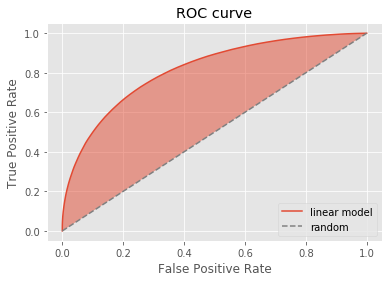

0.81470306689


In [38]:
dec_pred = dec.predict_proba(data_test.drop(cols_drop_dec, axis=1))
roc_curve(label_test, dec_pred)
print(metrics.roc_auc_score(label_test, dec_pred[:,1]))

0.81470306689

In [39]:
clf = linear_model.LogisticRegression()
param_grid = {'C': [0.01, 0.1, 1, 5]}
opt = model_selection.GridSearchCV(clf, param_grid, cv=3, n_jobs=2, return_train_score=True, scoring='roc_auc')

In [40]:
opt.fit(data_train[reg_used_cols], label_train)
gc.collect()
for i, c in enumerate(opt.best_estimator_.coef_[0]):
    print("%s: %f" % (data_train[reg_used_cols].columns[i], c))

NameError: name 'clf_df' is not defined

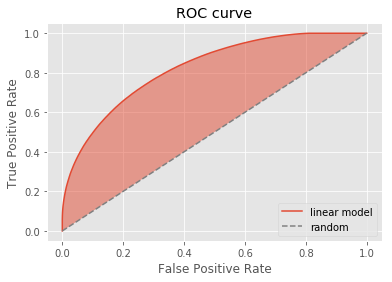

0.823198177896


In [41]:
reg_pred = opt.predict_proba(data_test[reg_used_cols])
roc_curve(label_test, reg_pred)
print(metrics.roc_auc_score(label_test, reg_pred[:,1]))

0.823378147562

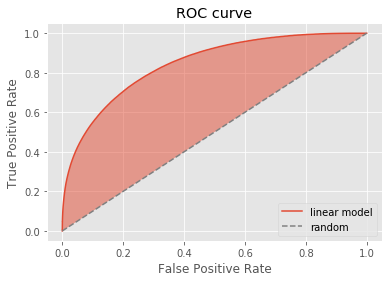

0.843545660871


In [44]:
mean_pred = (reg_pred + dec_pred) / 2
roc_curve(label_test, mean_pred)
print(metrics.roc_auc_score(label_test, mean_pred[:,1]))

0.843545660871

In [45]:
test_df = pd.read_csv("test_dataset.csv")

In [46]:
test_df.shape

(3504864, 15)

In [47]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,Id
0,1,1,2,1851.0,2029.0,UA,735,N386UA,113.0,ALB,ORD,723,7.0,38.0,0
1,1,1,2,1847.0,2029.0,CO,809,N15710,191.0,IAH,SNA,1347,7.0,24.0,1
2,1,1,2,1522.0,1622.0,MQ,4298,N676AE,28.0,ORD,PIA,130,3.0,29.0,2
3,1,1,2,2013.0,2303.0,NW,876,N780NC,90.0,MSP,SDF,603,6.0,14.0,3
4,1,1,2,1649.0,1727.0,FL,547,N920AT,83.0,ATL,BMI,533,5.0,10.0,4


In [48]:
test_df = test_df.fillna(0)

In [49]:
test_df["DayOfYear"] = test_df.apply(lambda x: getDaysFromYearStart(x["Month"], x["DayofMonth"]), axis=1)

In [50]:
test_df["AirTimeFrame"] = test_df["AirTime"].map(lambda x: math.log10(x // 30 + 1))

In [51]:
reclass_time(test_df, "DepTime", "DepHour", "DepMinute")
test_df["DepTotalMinutes"] = test_df["DepHour"] * 60 + test_df["DepMinute"]
test_df["DepTimeFrame"] = test_df["DepTotalMinutes"] // 15
test_df["DepHourOfYear"] = test_df["DayOfYear"] * 24 - (24 - test_df["DepHour"])

In [52]:
reclass_time(test_df, "ArrTime", "ArrHour", "ArrMinute")
test_df["ArrTotalMinutes"] = test_df["ArrHour"] * 60 + test_df["ArrMinute"]
test_df["ArrTimeFrame"] = test_df["ArrTotalMinutes"] // 15
test_df["ArrHourOfYear"] = test_df["DayOfYear"] * 24 - (24 - test_df["ArrHour"])

In [53]:
test_df["DepHourOfYearFrame"] = test_df["DepHourOfYear"] // 8
test_df["ArrHourOfYearFrame"] = test_df["ArrHourOfYear"] // 8

In [54]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,DepTotalMinutes,DepTimeFrame,DepHourOfYear,ArrHour,ArrMinute,ArrTotalMinutes,ArrTimeFrame,ArrHourOfYear,DepHourOfYearFrame,ArrHourOfYearFrame
0,1,1,2,1851.0,2029.0,UA,735,N386UA,113.0,ALB,...,1131,75,18,20,29,1229,81,20,2,2
1,1,1,2,1847.0,2029.0,CO,809,N15710,191.0,IAH,...,1127,75,18,20,29,1229,81,20,2,2
2,1,1,2,1522.0,1622.0,MQ,4298,N676AE,28.0,ORD,...,922,61,15,16,22,982,65,16,1,2
3,1,1,2,2013.0,2303.0,NW,876,N780NC,90.0,MSP,...,1213,80,20,23,3,1383,92,23,2,2
4,1,1,2,1649.0,1727.0,FL,547,N920AT,83.0,ATL,...,1009,67,16,17,27,1047,69,17,2,2


In [55]:
test_df = pd.merge(test_df, dhoy_origin_mean, on=['DepHourOfYearFrame', 'Origin'], how='left')
test_df = pd.merge(test_df, ahoy_dest_mean, on=['ArrHourOfYearFrame', 'Dest'], how='left')

In [56]:
with open('airport_info.json', 'r') as data_file:
    airport_data = json.load(fp = data_file)
    test_df["OTimeZone"] = test_df["Origin"].map(lambda x: airport_data[x]['Time Zone'])
    test_df["OLatitude"] = test_df["Origin"].map(lambda x: airport_data[x]['Latitude'])
    test_df["OLongitude"] = test_df["Origin"].map(lambda x: airport_data[x]['Longitude'])
    
    test_df["DTimeZone"] = test_df["Dest"].map(lambda x: airport_data[x]['Time Zone'])
    test_df["DLatitude"] = test_df["Dest"].map(lambda x: airport_data[x]['Latitude'])
    test_df["DLongitude"] = test_df["Dest"].map(lambda x: airport_data[x]['Longitude'])

In [57]:
test_df["OTimeZone"] = test_df["OTimeZone"].map(lambda x: int(x.split(':')[0]))
test_df["DTimeZone"] = test_df["DTimeZone"].map(lambda x: int(x.split(':')[0]))

In [58]:
test_df["OLtFrame"] = test_df["OLatitude"].astype('float').agg('floor')
test_df["DLtFrame"] = test_df["DLatitude"].astype('float').agg('floor')

test_df["OLgFrame"] = test_df["OLongitude"].astype('float').agg('floor')
test_df["DLgFrame"] = test_df["DLongitude"].astype('float').agg('floor')

In [59]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,OTimeZone,OLatitude,OLongitude,DTimeZone,DLatitude,DLongitude,OLtFrame,DLtFrame,OLgFrame,DLgFrame
0,1,1,2,1851.0,2029.0,UA,735,N386UA,113.0,ALB,...,-5,42.7482986,-73.8016968,-6,41.9785996,-87.9048004,42.0,41.0,-74.0,-88.0
1,1,1,2,1847.0,2029.0,CO,809,N15710,191.0,IAH,...,-6,29.9843998,-95.3414001,-8,33.6757011,-117.8679962,29.0,33.0,-96.0,-118.0
2,1,1,2,1522.0,1622.0,MQ,4298,N676AE,28.0,ORD,...,-6,41.9785996,-87.9048004,-6,40.6641998,-89.6932983,41.0,40.0,-88.0,-90.0
3,1,1,2,2013.0,2303.0,NW,876,N780NC,90.0,MSP,...,-6,44.882,-93.2218018,-5,38.1744003,-85.7360001,44.0,38.0,-94.0,-86.0
4,1,1,2,1649.0,1727.0,FL,547,N920AT,83.0,ATL,...,-5,33.6366997,-84.4281006,-6,40.4771004,-88.9159012,33.0,40.0,-85.0,-89.0


In [60]:
for orig, mean in mean_names.items():
    test_df = reclassMeanOpt(test_df, df, orig, mean)
    gc.collect()
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,PlaneChance,AirFrameChance,DepFrameChance,ArrFrameChance,OTZChance,DTZChance,OLtChance,DLtChance,OLgChance,DLgChance
0,1,1,2,1851.0,2029.0,UA,735,N386UA,113.0,ALB,...,-0.739112,NaN,-0.673394,-0.515531,-0.859482,-0.840467,-0.990507,-0.727910,-0.874539,-0.727904
1,1,1,2,1847.0,2029.0,CO,809,N15710,191.0,IAH,...,-0.696971,NaN,-0.673394,-0.515531,-0.767693,-0.828512,-0.722501,-0.944738,-0.706490,-0.868891
2,1,1,2,1522.0,1622.0,MQ,4298,N676AE,28.0,ORD,...,-0.545388,-1.199295,-0.603187,-0.757207,-0.767693,-0.840467,-0.643343,-0.711998,-0.523153,-1.165108
3,1,1,2,2013.0,2303.0,NW,876,N780NC,90.0,MSP,...,-1.239633,NaN,-0.108377,-0.022839,-0.767693,-0.833031,-1.068220,-0.842251,-1.050608,-0.757525
4,1,1,2,1649.0,1727.0,FL,547,N920AT,83.0,ATL,...,-0.923573,-0.895467,-0.699574,-0.607884,-0.859482,-0.840467,-0.799550,-0.711998,-0.741098,-0.771654


In [61]:
gc.collect()

66

In [71]:
test_df[test_df["Dest"] == 'DFW']['Dest_label']

7          82
17         82
30         82
42         82
47         82
49         82
50         82
100        82
120        82
156        82
169        82
195        82
225        82
255        82
257        82
272        82
275        82
294        82
330        82
338        82
358        82
407        82
419        82
433        82
446        82
475        82
529        82
532        82
573        82
582        82
           ..
3504164    82
3504217    82
3504229    82
3504329    82
3504392    82
3504441    82
3504448    82
3504466    82
3504470    82
3504472    82
3504508    82
3504533    82
3504595    82
3504613    82
3504621    82
3504624    82
3504627    82
3504628    82
3504639    82
3504640    82
3504687    82
3504692    82
3504701    82
3504727    82
3504785    82
3504796    82
3504826    82
3504836    82
3504841    82
3504854    82
Name: Dest_label, Length: 140524, dtype: int16

In [70]:
test_df["Dest_label"] = test_df["Dest"].astype('category').cat.codes

In [62]:
test_df.fillna(0, inplace=True)

In [63]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,PlaneChance,AirFrameChance,DepFrameChance,ArrFrameChance,OTZChance,DTZChance,OLtChance,DLtChance,OLgChance,DLgChance
0,1,1,2,1851.0,2029.0,UA,735,N386UA,113.0,ALB,...,-0.739112,0.000000,-0.673394,-0.515531,-0.859482,-0.840467,-0.990507,-0.727910,-0.874539,-0.727904
1,1,1,2,1847.0,2029.0,CO,809,N15710,191.0,IAH,...,-0.696971,0.000000,-0.673394,-0.515531,-0.767693,-0.828512,-0.722501,-0.944738,-0.706490,-0.868891
2,1,1,2,1522.0,1622.0,MQ,4298,N676AE,28.0,ORD,...,-0.545388,-1.199295,-0.603187,-0.757207,-0.767693,-0.840467,-0.643343,-0.711998,-0.523153,-1.165108
3,1,1,2,2013.0,2303.0,NW,876,N780NC,90.0,MSP,...,-1.239633,0.000000,-0.108377,-0.022839,-0.767693,-0.833031,-1.068220,-0.842251,-1.050608,-0.757525
4,1,1,2,1649.0,1727.0,FL,547,N920AT,83.0,ATL,...,-0.923573,-0.895467,-0.699574,-0.607884,-0.859482,-0.840467,-0.799550,-0.711998,-0.741098,-0.771654


In [65]:
test_clf_df = pd.get_dummies(test_df[list(set(dec_used_cols + reg_used_cols))], columns=cat_cols_dec)

KeyError: "['Dest_label' 'Origin_label'] not in index"

In [ ]:
test_clf_df.shape

In [ ]:
test_clf_df.head()

In [ ]:
test_pred_dec = dec.predict_proba(test_clf_df.drop(cols_drop_dec, axis=1))

In [ ]:
test_pred_reg = opt.predict_proba(test_clf_df[reg_used_cols])

In [ ]:
test_pred = (test_pred_dec + test_pred_reg) / 2

In [ ]:
test_pred

In [ ]:
test_pred_df = pd.DataFrame(test_pred[:, 1], columns=["Prediction1"])

In [ ]:
test_pred_df.index.name = "Id"

In [ ]:
test_pred_df.head()

In [ ]:
test_pred_df.to_csv("sample_1.csv")
notif.show_toast("Written to csv", "Ready to submit", duration=10)

In [125]:
#Free ALOT of memory
test_df = test_pred_df = None
gc.collect()

48